In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# create directory if not exist
INPUT_DIR = '../data'
OUTPUT_DIR = '../out'
IMG_DIR = '../img'
assert(Path(INPUT_DIR).is_dir())
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(IMG_DIR).mkdir(parents=True, exist_ok=True)

# Data

## Load Training Data

In [3]:
training_file = INPUT_DIR + '/covid_training.tsv'
train_df = pd.read_csv(training_file, sep='\t', usecols=[0,1,2])
train_df.head()

,tweet_id,text,q1_label
0,1241025578527903750,For the average American the best way to tell ...,no
1,1240467080954228737,this is fucking bullshit,no
2,1240716889162018816,Can y’all please just follow the government’s ...,no
3,1241062514886090754,No offense but the corona virus disappearing b...,no
4,1241447017945223169,This is the face of someone who just spent 9 h...,yes


In [4]:
X_train = pd.Series(train_df['text'].str.lower().str.split().values.copy(), index=train_df['tweet_id'])
X_train

tweet_id
1241025578527903750    [for, the, average, american, the, best, way, ...
1240467080954228737                        [this, is, fucking, bullshit]
1240716889162018816    [can, y’all, please, just, follow, the, govern...
1241062514886090754    [no, offense, but, the, corona, virus, disappe...
1241447017945223169    [this, is, the, face, of, someone, who, just, ...
                                             ...                        
1237310167814791168    [it's, like, suicide, but, minus, the, haram, ...
1237460460749766657    [the, first, silicon, valley, death, from, cov...
1237068715314892802    [breakthrough:, chloroquine, phosphate, --, an...
1237395939171561472    [i, know, everyone, is, freaking, out, about, ...
1237404677307760640    [ebola, has, a, 50%, death, rate., if, you, go...
Length: 399, dtype: object

In [5]:
y_train = pd.Series(train_df['q1_label'].astype('category').values.copy(), index=train_df['tweet_id'])
print(dict(enumerate(y_train.cat.categories)))

{0: 'no', 1: 'yes'}


## Load Test Data

In [6]:
testing_file = INPUT_DIR + '/covid_test_public.tsv'
test_df = pd.read_csv(testing_file, sep='\t', usecols=[0,1,2], names=train_df.columns)
X_test = pd.Series(test_df['text'].str.lower().str.split().values.copy(), index=test_df['tweet_id'])
y_test = pd.Series(test_df['q1_label'].astype('category').values.copy(), index=test_df['tweet_id'])
test_df.head()

,tweet_id,text,q1_label
0,1236932313642143745,1/ Many of you ask me why I take the COVID-19 ...,no
1,1236289649737371648,Panic buying and stockpiling of toilet roll co...,yes
2,1237501242567544835,Everyone can help prevent the spread of #COVID...,no
3,1237029903112888321,Isa sa pinakamaganda mong maa-ambag about COVI...,no
4,1237270988334592001,BREAKING: Department of Health announces 11 mo...,yes


## Inspect Data

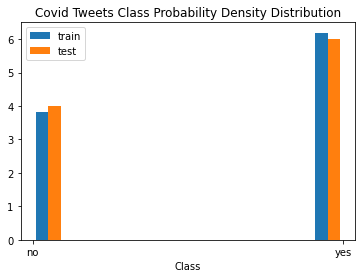

In [7]:
plt.hist([train_df['q1_label'], test_df['q1_label']], density=True, label=['train','test'])
plt.title('Covid Tweets Class Probability Density Distribution')
plt.xlabel('Class')
plt.legend()
plt.savefig(IMG_DIR + '/class_dist')

In [8]:
# Check for empty/too short tweets
print('Minimum length of tweets: ', X_train.apply(len).min())

Minimum length of tweets:  4


In [9]:
# Check for unknown classes
y_train.unique()

['no', 'yes']
Categories (2, object): ['no', 'yes']

# Model

In [10]:
CLASSES = y_train.unique()
CLASSES

['no', 'yes']
Categories (2, object): ['no', 'yes']

## Build Vector Space Representation

In [11]:
from collections import Counter
vec_space_df = pd.DataFrame(X_train.apply(Counter).tolist(), index=X_train.index).fillna(0)
vec_space_df.iloc[:5,-5:]

,obviously,ebolaâbut,34x,https://t.co/bcyoeedray,https://t.co/ga2rdghpiq
tweet_id,,,,,
1241025578527903750,0.0,0.0,0.0,0.0,0.0
1240467080954228737,0.0,0.0,0.0,0.0,0.0
1240716889162018816,0.0,0.0,0.0,0.0,0.0
1241062514886090754,0.0,0.0,0.0,0.0,0.0
1241447017945223169,0.0,0.0,0.0,0.0,0.0


## Class Probability

In [12]:
class_log_proba = np.log10((y_train.value_counts()/len(y_train)))

## Vocabulary Probability

In [13]:
# P(w | c) = freq / total
ov_word_freqs = pd.DataFrame(dtype=np.int)
ov_word_totals = pd.Series(dtype=np.int)

In [14]:
fv_word_freqs = pd.DataFrame(dtype=np.int)
fv_word_totals = pd.Series(dtype=np.int)

### Count Words

In [15]:
for c in CLASSES:
    # frequency per class c = sum all rows where target is c
    ov_word_freqs[c] = vec_space_df[y_train==c].sum()
    # total per class = sum all word freqs where target is c
    ov_word_totals[c] = ov_word_freqs[c].sum()
print('OV Word Frequencies')
print(ov_word_freqs)
print('\nOV Word Totals')
print(ov_word_totals)

OV Word Frequencies
                            no    yes
for                       34.0   90.0
the                      132.0  321.0
average                    1.0    0.0
american                   4.0    7.0
best                       4.0    2.0
...                        ...    ...
obviously                  0.0    1.0
ebolaâbut                0.0    1.0
34x                        0.0    1.0
https://t.co/bcyoeedray    0.0    1.0
https://t.co/ga2rdghpiq    0.0    1.0

[4304 rows x 2 columns]

OV Word Totals
no     3741.0
yes    8844.0
dtype: float64


In [16]:
mask_less_than_2 = ov_word_freqs.sum(axis=1) >= 2
fv_word_freqs = ov_word_freqs.loc[mask_less_than_2].copy()
for c in CLASSES:
    fv_word_totals[c] = fv_word_freqs[c].sum()
print('FV Word Frequencies')
print(fv_word_freqs)
print('\nFV Word Totals')
print(fv_word_totals)

FV Word Frequencies
                no    yes
for           34.0   90.0
the          132.0  321.0
american       4.0    7.0
best           4.0    2.0
way            5.0    6.0
...            ...    ...
ng             0.0    2.0
na             0.0    2.0
60s.           0.0    2.0
chloroquine    0.0    2.0
rate.          0.0    2.0

[1193 rows x 2 columns]

FV Word Totals
no     2833.0
yes    6641.0
dtype: float64


### Smoothing

In [17]:
def smooth(freqs: pd.DataFrame, totals: pd.DataFrame, classes, delta: float):
    freqs_ = freqs.copy()
    totals_ = totals.copy()
    size_vocab = len(freqs_)
    for c in classes:
        freqs_[c] += delta
        totals_[c] += delta * size_vocab
    return freqs_, totals_

In [18]:
delta = 0.01
ov_smoothed_freqs, ov_smoothed_totals = smooth(ov_word_freqs, ov_word_totals, CLASSES, delta)
fv_smoothed_freqs, fv_smoothed_totals = smooth(fv_word_freqs, fv_word_totals, CLASSES, delta)
print('OV Smoothed Word Totals')
print(ov_smoothed_totals)
print('\nFV Smoothed Word Totals')
print(fv_smoothed_totals)

OV Smoothed Word Totals
no     3784.04
yes    8887.04
dtype: float64

FV Smoothed Word Totals
no     2844.93
yes    6652.93
dtype: float64


### Word Probability

In [19]:
ov_model = np.log10(ov_smoothed_freqs / ov_smoothed_totals)
fv_model = np.log10(fv_smoothed_freqs / fv_smoothed_totals)

# Prediction and Evaluation

## Define Functions

### Trace Files

In [20]:
def predict_single(model: pd.DataFrame, class_log_proba: pd.Series, word_list: list):
    V = model.index
    classes = class_log_proba.index
    
    # dict containing (class -> score) pairs
    scores_per_class = {
        # key := class c
        c : 
        # val := log(P(class)) + sum of log(w|class) for w in V
        class_log_proba[c] + sum([
            model.loc[word, c] for word in word_list if word in V
        ])
        
        for c in classes
    }
    
    # class with max score
    c = max(scores_per_class, key=scores_per_class.get)
    return c, format(scores_per_class[c], '.2E')  # class, score

def predict(model: pd.DataFrame, class_log_proba: pd.Series, X):
    df = X.apply(lambda x: predict_single(model, class_log_proba, x))
    return pd.DataFrame(df.tolist(), index=df.index, columns=['y_pred', 'score'])

def trace_predict(model: pd.DataFrame, class_log_proba: pd.Series, X, y, path):
    # mapping boolean to str
    verdict_mapping = {True:'correct',False:'wrong'}
    
    # make dataframe with columns [y_pred, score, y_true, verdict]
    trace_df = predict(model, class_log_proba, X)
    trace_df['y_true'] = y
    trace_df['verdict'] = (trace_df.y_true == trace_df.y_pred).replace(verdict_mapping)
    
    np.savetxt(path, trace_df.reset_index(), delimiter='  ', fmt='%s')
    return trace_df

### Overall Evaluation Files

In [21]:
def confusion_matrix(y_true: pd.Series, y_pred: pd.Series):
    positive_pred = y_pred == 'yes'
    positive_target = y_true == 'yes'
    
    N = len(y_true)
    np = len(y_true[positive_target])
    nn = N - np
    
    tp, fp = (y_true[positive_pred] == y_pred[positive_pred]).value_counts().reindex([True, False])
    fn = np - tp
    tn = nn - fp
    
    return pd.DataFrame([
        [tn,fp],
        [fn,tp]
    ], index=('no', 'yes'), columns=('no', 'yes'))

def accuracy_scores(tn, fp, fn, tp):
    N = sum((tn, fp, fn, tp))
    return pd.Series([
        (tp+tn)/N, (tp+tn)/N
    ], index=('yes', 'no'), dtype=np.float64, name='accuracy')

def precision_scores(tn, fp, fn, tp):
    return pd.Series([
        tp/(tp+fp), tn/(fn+tn)
    ], index=('yes', 'no'), dtype=np.float64, name='precision')

def recall_scores(tn, fp, fn, tp):
    return pd.Series([
        tp/(tp+fn), tn/(tn+fp)
    ], index=('yes', 'no'), dtype=np.float64, name='recall')

def f1_scores(tn, fp, fn, tp):
    prec = precision_scores(tn, fp, fn, tp)
    reca = recall_scores(tn, fp, fn, tp)
    return (2 * prec * reca / (prec + reca)).rename('f1')

def eval_model(y_true: pd.Series, y_pred: pd.Series, path):
    # outcomes = (tn, fp, fn, tp)
    outcomes = confusion_matrix(y_true, y_pred).to_numpy().ravel()
    
    # combine scores in a dataframe
    df = pd.concat([get_scores(*outcomes) for get_scores in (accuracy_scores, precision_scores, recall_scores, f1_scores)], axis=1)
    
    # format output scores
    lines = ['{:.4f}  {:.4f}\n'.format(*df[col].tolist()) for col in df.columns]
    
    # format accuracy
    lines[0] = lines[0].rsplit(' ', 1)[-1]
    
    # write scores to file
    with open(path, 'w') as f:
        f.writelines(lines)

    return df

## Evaluate

### NB-BOW-OV Outputs

In [22]:
# produce OV trace file
ov_trace = trace_predict(ov_model, class_log_proba, X_test, y_test, OUTPUT_DIR + '/trace_NB-BOW-OV.txt')
ov_trace.head()

,y_pred,score,y_true,verdict
tweet_id,,,,
1236932313642143745,no,-9.33E+01,no,correct
1236289649737371648,yes,-3.30E+01,yes,correct
1237501242567544835,yes,-1.05E+02,no,wrong
1237029903112888321,yes,-6.79E+01,no,wrong
1237270988334592001,yes,-4.72E+01,yes,correct


In [23]:
# evaluate OV model performance
eval_model(ov_trace.y_true, ov_trace.y_pred, OUTPUT_DIR + '/eval_NB-BOW-OV.txt')

,accuracy,precision,recall,f1
yes,0.672727,0.666667,0.909091,0.769231
no,0.672727,0.700000,0.318182,0.437500


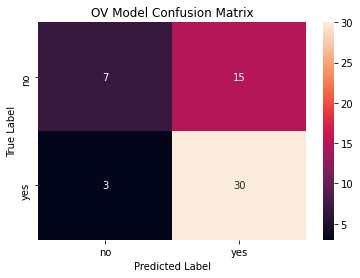

In [24]:
# plot OV confusion matrix
sns.heatmap(confusion_matrix(ov_trace.y_true, ov_trace.y_pred), annot=True, fmt="d")
plt.title('OV Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(IMG_DIR + '/ov_conf_mat')

### NB-BOW-FV Outputs

In [25]:
# produce FV trace file
fv_trace = trace_predict(fv_model, class_log_proba, X_test, y_test, OUTPUT_DIR + '/trace_NB-BOW-FV.txt')
fv_trace.head()

,y_pred,score,y_true,verdict
tweet_id,,,,
1236932313642143745,yes,-7.04E+01,no,wrong
1236289649737371648,yes,-2.75E+01,yes,correct
1237501242567544835,yes,-8.90E+01,no,wrong
1237029903112888321,yes,-6.14E+01,no,wrong
1237270988334592001,yes,-3.75E+01,yes,correct


In [26]:
# evaluate FV model performance
eval_model(fv_trace.y_true, fv_trace.y_pred, OUTPUT_DIR + '/eval_NB-BOW-FV.txt')

,accuracy,precision,recall,f1
yes,0.745455,0.720930,0.939394,0.815789
no,0.745455,0.833333,0.454545,0.588235


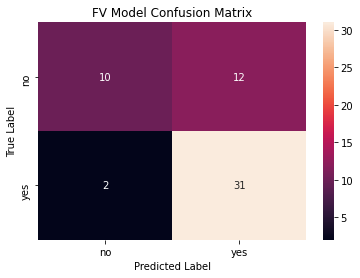

In [27]:
# plot FV confusion matrix
sns.heatmap(confusion_matrix(fv_trace.y_true, fv_trace.y_pred), annot=True, fmt="d")
plt.title('FV Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(IMG_DIR + '/fv_conf_mat')